# Filter study for Cryoscope

**Goal**: Understand action of savgol filter and see how signal shape change changing filter parameters

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import pickle


from pathlib import Path
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.signal import lfilter

from qibocal.protocols.two_qubit_interaction.cryoscope import _plot, CryoscopeData, CryoscopeResults, CryoscopeType 
from qibocal.protocols.ramsey.utils import fitting


FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(50), np.zeros(10)])


[Qibo 0.2.12|INFO|2024-12-05 09:40:29]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-05 09:40:29]: Loading platform dummy


In [2]:
def _fit(data: CryoscopeData, savgol: bool, demod: bool, window_length: int) -> CryoscopeResults:

    nyquist_order = 0

    fitted_parameters = {}
    detuning = {}
    amplitude = {}
    step_response = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        x = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(x, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (x[1] - x[0])
        X_exp = 1 - 2 * data[(qubit, "MX")].prob_1
        Y_exp = 1 - 2 * data[(qubit, "MY")].prob_1

        norm_data = X_exp + 1j * Y_exp

        # demodulation frequency found by fitting sinusoidal
        demod_freq = -fitted_parameters[qubit, "MY"][2] / 2 / np.pi * sampling_rate

        # to be used in savgol_filter
        derivative_window_length = window_length / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        derivative_window_size += (derivative_window_size + 1) % 2

        # find demodulatation frequency
        if demod:
            demod_data = np.exp(2 * np.pi * 1j * x * demod_freq) * (norm_data)
        else:
            demod_data = norm_data
            
        # compute phase
        phase = np.unwrap(np.angle(demod_data))

        # compute detuning

        if savgol:
            phase = scipy.signal.savgol_filter(
                phase / (2 * np.pi),
                window_length=derivative_window_size,
                polyorder=2,
                deriv=1,
                mode = "nearest"
                )
            raw_detuning = (phase * sampling_rate
            )
        else:
            phase = phase/(2*np.pi)
            raw_detuning = (phase*sampling_rate)

        # real detuning (reintroducing demod_freq)
        if demod: 
            detuning[qubit] = (
                raw_detuning - demod_freq + sampling_rate * nyquist_order
            ).tolist()
        else: 
            detuning[qubit] = (
            raw_detuning + sampling_rate * nyquist_order
            ).tolist()

        # params from flux_amplitude_frequency_protocol
        params = [1.9412681243469971, -0.012534948170662627, 0.0005454772278201887]

        # invert frequency amplitude formula
        p = np.poly1d(params)
        amplitude[qubit] = [max((p - freq).roots).real for freq in detuning[qubit]]

        # compute step response
        step_response[qubit] = (
            np.array(amplitude[qubit]) / data.flux_pulse_amplitude
        ).tolist()

    return CryoscopeResults(
        amplitude=amplitude,
        detuning=detuning,
        step_response=step_response,
        fitted_parameters=fitted_parameters,
    ), raw_detuning, phase

**Loading data**

In [3]:
def load_cryoscope_data(file_path: str, flux_pulse_amplitude: float) -> CryoscopeData:

    cryoscope_data = CryoscopeData(flux_pulse_amplitude = flux_pulse_amplitude)
    
    data_npz = np.load(file_path)
    D1MX = np.rec.array(data_npz['["D1", "MX"]'])
    D1MY = np.rec.array(data_npz['["D1", "MY"]'])
    
    data_dict = {
        ("D1", "MX") : D1MX,
        ("D1", "MY") : D1MY
    }

    cryoscope_data.data = data_dict

    return cryoscope_data


In [4]:
# Load data
data_path = Path.cwd().parent / "cryo_material" / "cryoscope" / "data" / "cryoscope-0"
results_json = data_path / "results.json"
data_json = data_path / "data.json"

with open(data_json, "r") as file:
    data = json.load(file)

with open(results_json, "r") as file:
    results = json.load(file)

print(data)
print(results)

{'"flux_pulse_amplitude"': 0.1}
{'"fitted_parameters"': {'["D1", "MX"]': [-0.00029639988763097147, 0.9259233868264589, 0.11297702572931177, 0.6811588111300295, 0.000200444727454511], '["D1", "MY"]': [-0.04330729231685593, 0.8053304242090724, 0.10001152244951339, -0.4561057364051088, 2.2940053954883843e-20]}, '"detuning"': {'"D1"': [0.0009089261001269961, 0.000771851252188812, 0.0006347764042506296, 0.0004977015563124541, 0.0006846099963171426, 0.0013814410767795885, 0.0009524330694135, 0.0020828945176104875, 0.00451965116963066, 0.008056748847200531, 0.010930627775662245, 0.01474036564921474, 0.01760471010827338, 0.018092453186971134, 0.018848063875241225, 0.019652778635600485, 0.020640357880029162, 0.020271250427942165, 0.020203698291166236, 0.020596376668128507, 0.020954302520328046, 0.021055945473469714, 0.020656135007137394, 0.019722949412587443, 0.018482234744427915, 0.017193251219308283, 0.016571813635514302, 0.01759950666098585, 0.018236536283483897, 0.0190546229767291, 0.019108

In [5]:
flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", flux_pulse_amplitude)

### Changing savgol filter values

In [6]:
# applicazione del filtro sui dati demodulati vs non demodulati
_, _, savgol_demod = _fit(cryoscope_data, True, True, 7)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False, 7)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True, 7)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False, 7)

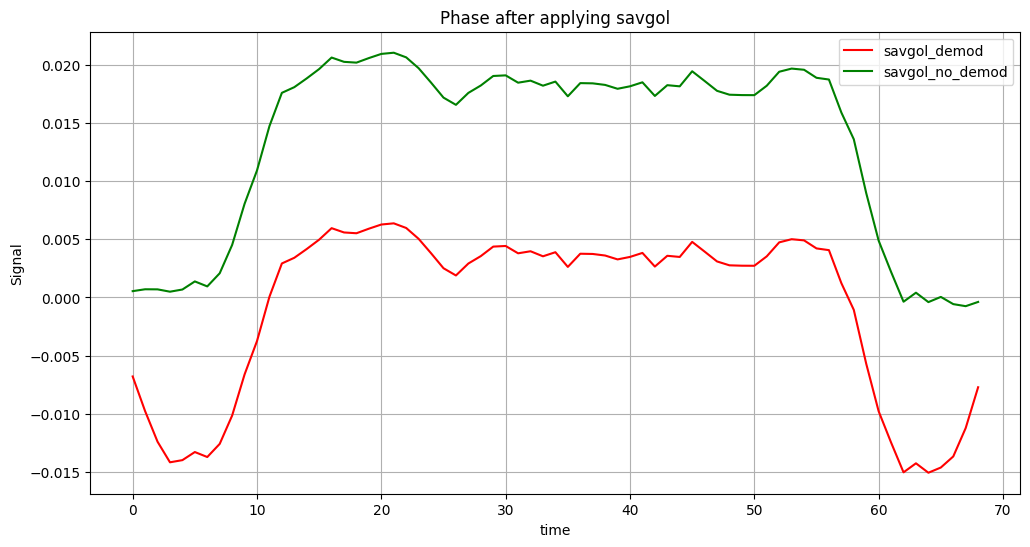

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(savgol_demod, color="red", label="savgol_demod")
plt.plot(savgol_no_demod, color="green", label="savgol_no_demod")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Phase after applying savgol")
plt.legend()
plt.grid()
plt.show()

In [16]:
#applicazione del filtro sui dati demodulati vs non demodulati
_, _, savgol_demod = _fit(cryoscope_data, True, True, 3)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False, 3)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True, 3)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False, 3)

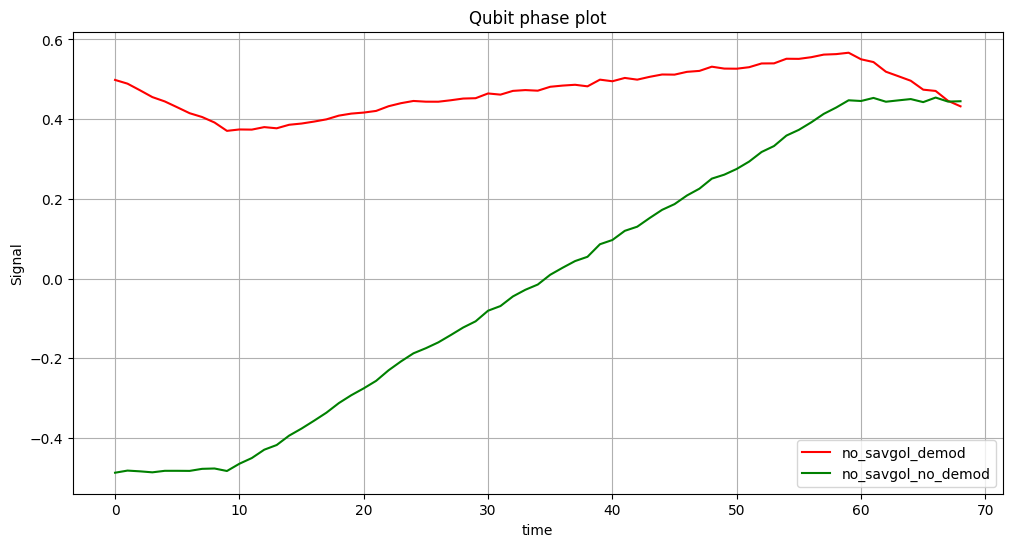

In [7]:
plt.figure(figsize=(12, 6)) 
plt.plot(no_savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(no_savgol_no_demod, color = "green", label="no_savgol_no_demod")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Qubit phase plot")
plt.legend()
plt.grid()
plt.show()

The following plot shows the phase after the application of the `savgol` filter with window length of 3 and `nearest` option for computing derivative and approximation on the margins

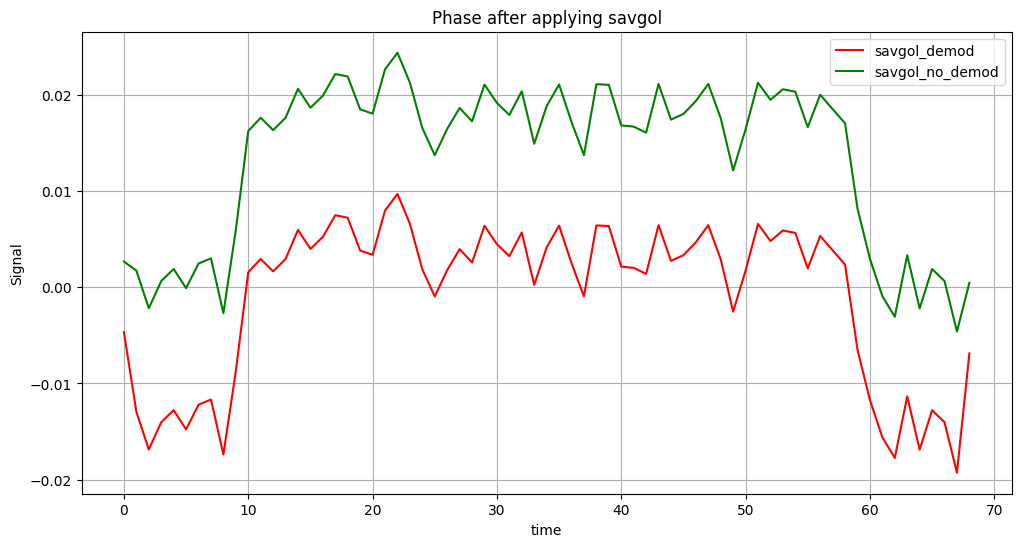

In [8]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="savgol_demod")
plt.plot(savgol_no_demod, color = "green", label="savgol_no_demod")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Phase after applying savgol")
plt.legend()
plt.grid()
plt.show()

In [9]:
#applicazione del filtro sui dati demodulati vs non demodulati, nearest, window length 5
_, _, savgol_demod = _fit(cryoscope_data, True, True, 5)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False, 5)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True, 5)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False, 5)

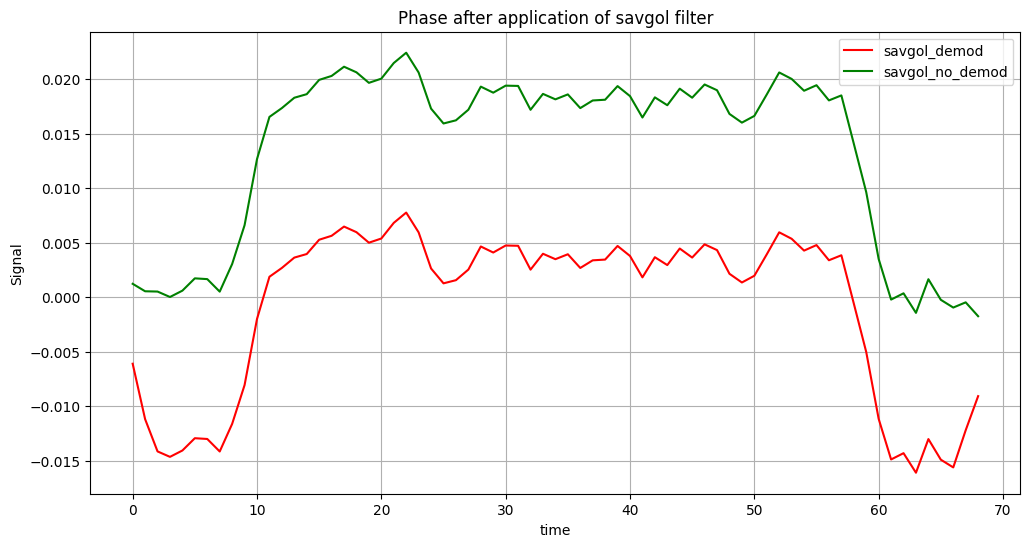

In [10]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="savgol_demod")
plt.plot(savgol_no_demod, color = "green", label="savgol_no_demod")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Phase after application of savgol filter")
plt.legend()
plt.grid()
plt.show()

The following plot results from the application of the `savgol` filter with a starting value of 3 for the window length and without applying the nearest smoothing to the borders

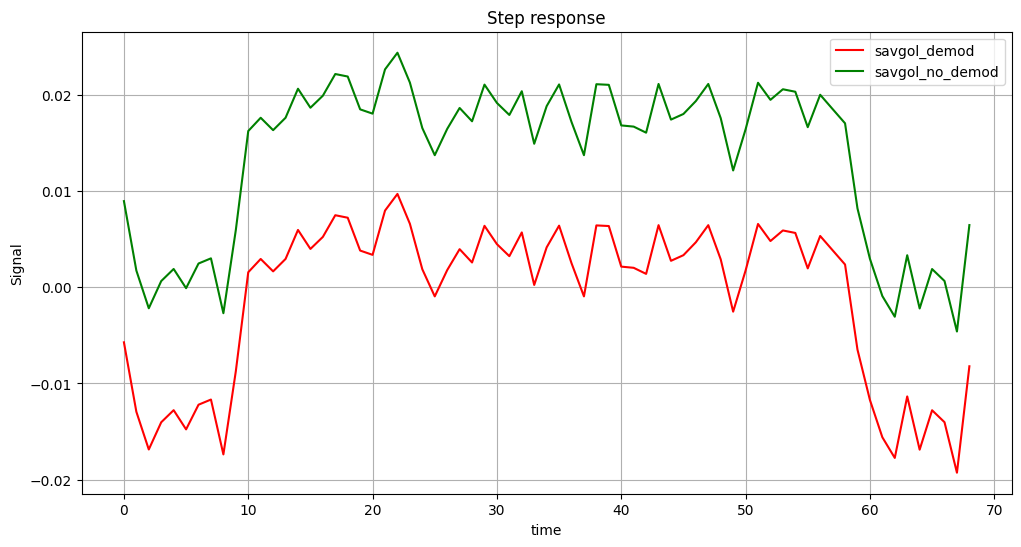

In [ ]:
#commented to not re-run by accident
#no nearest
#plt.figure(figsize=(12, 6)) 
#plt.plot(savgol_demod, color = "red", label="savgol_demod")
#plt.plot(savgol_no_demod, color = "green", label="savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
#plt.xlabel("time")
#plt.ylabel("Signal")
#plt.title("Step response")
#plt.legend()
#plt.grid()
#plt.show()

In [42]:
#lists for phase objects
savgol_demod = []
savgol_no_demod = []
no_savgol_demod = []
no_savgol_no_demod = []

#lists for CryoscopeResults objects
result_svg_dem = []
result_svg_no_dem = [] 
result_no_svg_dem = []
result_no_svg_no_dem = []

for i in range(3, 10):
    res_svg_dem, _, svg_dem = _fit(cryoscope_data, True, True, i)
    savgol_demod.append(svg_dem), result_svg_dem.append(res_svg_dem)

    res_svg_no_dem, _, svg_no_dem = _fit(cryoscope_data, True, False, i)
    savgol_no_demod.append(svg_no_dem), result_svg_no_dem.append(res_svg_no_dem)

    res_no_svg_dem, _, no_svg_dem = _fit(cryoscope_data, False, True, i)
    no_savgol_demod.append(no_svg_dem), result_no_svg_dem.append(res_no_svg_dem)

    res_no_svg_no_dem, _, no_svg_no_dem = _fit(cryoscope_data, False, False, i)
    no_savgol_no_demod.append(no_svg_no_dem), result_no_svg_no_dem.append(res_no_svg_no_dem)

In [43]:
#save lists 

with open('savgol_data.pkl', 'wb') as file:
    pickle.dump({
        "savgol_demod": savgol_demod,
        "savgol_no_demod": savgol_no_demod,
        "no_savgol_demod": no_savgol_demod,
        "no_savgol_no_demod": no_savgol_no_demod,
    }, file)

with open('CryoscopeResults.pkl', 'wb') as file:
    pickle.dump({
        "savgol_demod": result_svg_dem,
        "savgol_no_demod": result_svg_no_dem,
        "no_savgol_demod": result_no_svg_dem,
        "no_savgol_no_demod": result_no_svg_no_dem,
    }, file)

In [44]:
print(savgol_demod[0])

[-0.00466472 -0.01293832 -0.01686081 -0.0140313  -0.01277389 -0.01477128
 -0.01220785 -0.01166952 -0.01737417 -0.00872492  0.00156433  0.00294372
  0.00165505  0.002945    0.00596136  0.00398637  0.00523611  0.00749075
  0.00723035  0.00381709  0.00337173  0.0079711   0.0097049   0.00660103
  0.00187188 -0.00094697  0.00178325  0.00396294  0.00257787  0.00638959
  0.00448467  0.00323374  0.00570172  0.00024138  0.00415043  0.00640722
  0.0025042  -0.00094623  0.00643117  0.00636678  0.00214787  0.0020241
  0.0013931   0.00645765  0.00275226  0.00333646  0.00467932  0.00645683
  0.00290449 -0.00253402  0.00173989  0.0065816   0.00480784  0.00590703
  0.00564864  0.00196519  0.00533404  0.0038473   0.00236705 -0.00648103
 -0.01171145 -0.01558952 -0.01773851 -0.01134525 -0.01687983 -0.01278277
 -0.0140253  -0.01927681 -0.00687202]


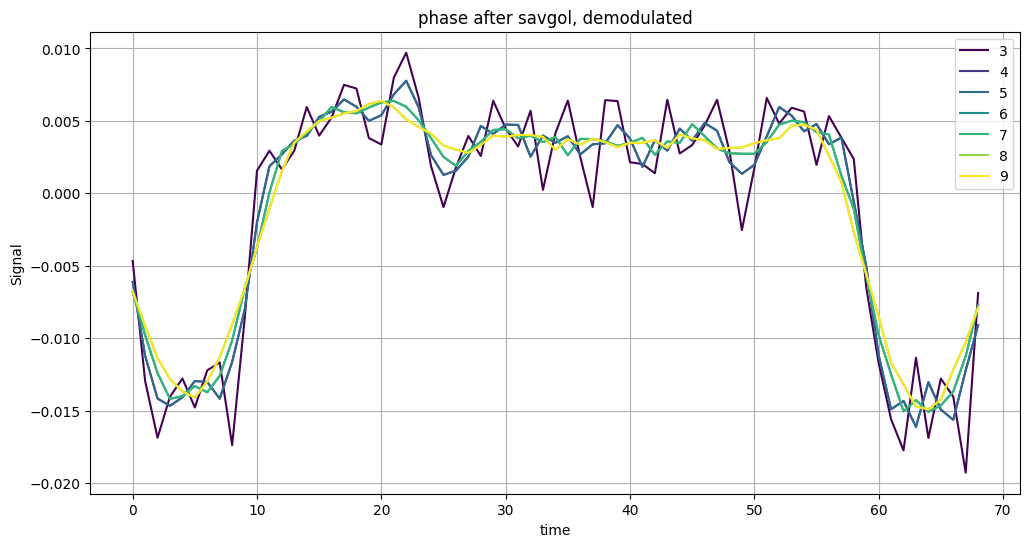

In [45]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6)) 

for i, phase in enumerate(savgol_demod):
    plt.plot(phase, color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("phase after savgol, demodulated")
plt.legend()
plt.grid()
plt.show()

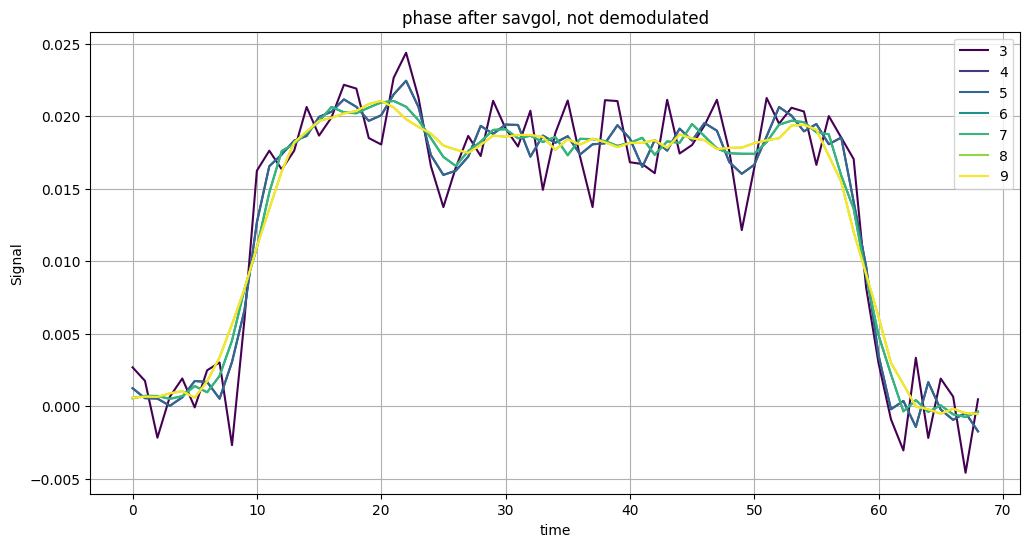

In [46]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6)) 

for i, phase in enumerate(savgol_no_demod):
    plt.plot(phase, color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("phase after savgol, not demodulated")
plt.legend()
plt.grid()
plt.show()

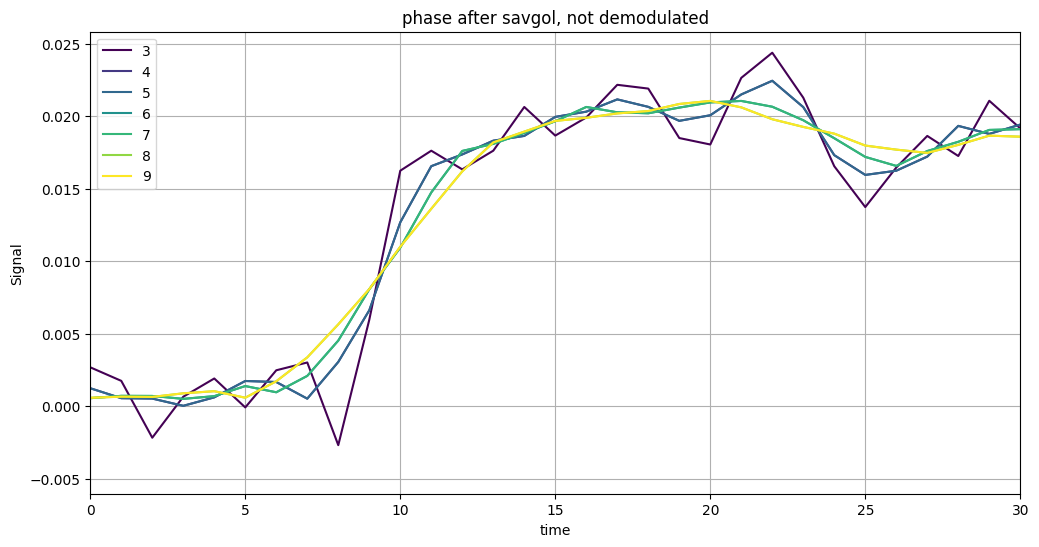

In [47]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6)) 

for i, phase in enumerate(savgol_no_demod):
    plt.plot(phase, color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.xlim(0,30)
plt.title("phase after savgol, not demodulated")
plt.legend()
plt.grid()
plt.show()

Control demodulated phase plot which should be the same for each window length as I haven't applied the filter yet.

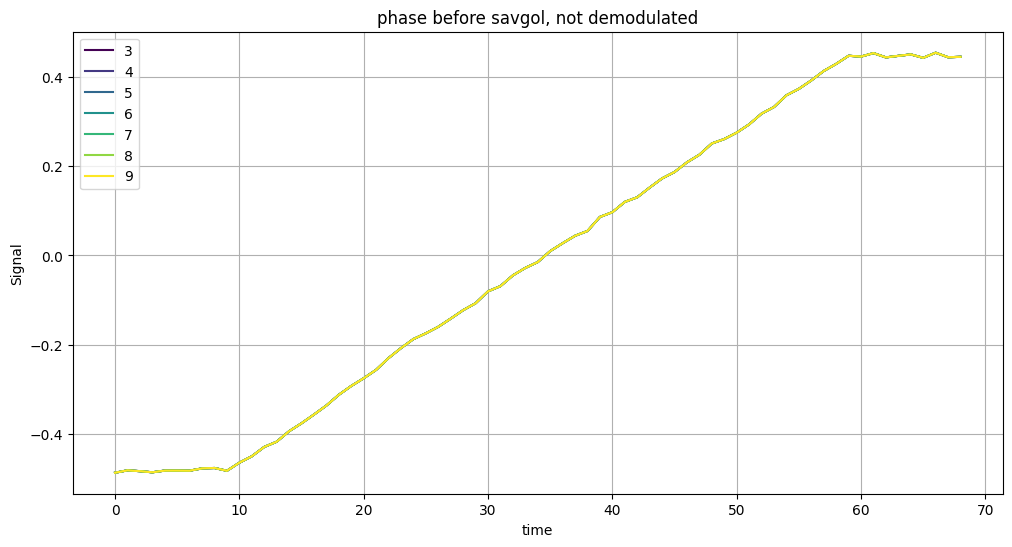

In [48]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6)) 

for i, phase in enumerate(no_savgol_no_demod):
    plt.plot(phase, color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("phase before savgol, not demodulated")
plt.legend()
plt.grid()
plt.show()

### Detuning plots

In [31]:
print(result_svg_no_dem[0].amplitude["D1"])

[0.03650036691436605, 0.028239730468929372, 0.0032285463335671692, 0.011136668788660336, 0.029879340381031166, 0.0032285463335671692, 0.03488050757579113, 0.038993833852148996, 0.0032285463335671692, 0.05610575949236268, 0.09320781537062554, 0.09707327231307329, 0.09346713847329442, 0.09707678809102906, 0.10501902542868123, 0.0998925585851247, 0.10316703710005184, 0.10881798253226542, 0.1081808663641885, 0.0994404425449157, 0.09824070125248197, 0.10998327723863571, 0.11408745326161805, 0.10662493154393803, 0.0940839168488159, 0.0857066125198203, 0.09383229535807455, 0.09983010944017645, 0.0960637293562183, 0.10609688658007789, 0.10121128258182709, 0.09786589979728676, 0.10435991894224263, 0.08933767853565783, 0.1003286998064816, 0.1061410119332742, 0.09585911595291118, 0.08570891232570696, 0.10620092500344883, 0.10603974034736846, 0.09486297153231579, 0.09451442008913365, 0.09271633178466361, 0.10626715481651872, 0.09654629905274359, 0.09814503914219137, 0.10172162435578046, 0.10626508

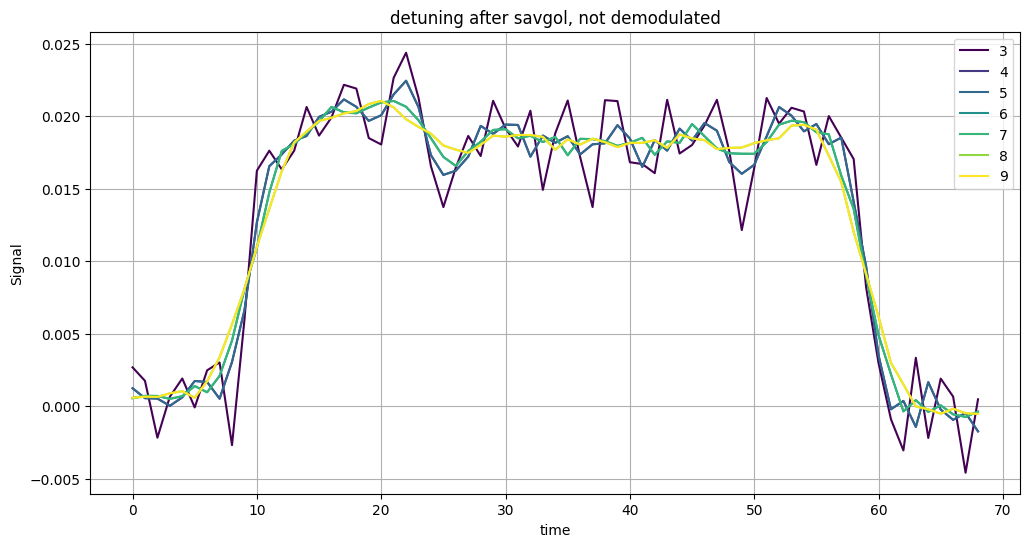

In [34]:
colors = plt.cm.viridis(np.linspace(0, 1, len(result_svg_no_dem)))

plt.figure(figsize=(12, 6)) 

for i, detuning in enumerate(result_svg_no_dem):
    plt.plot(detuning.detuning["D1"], color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("detuning after savgol, not demodulated")
plt.legend()
plt.grid()
plt.show()

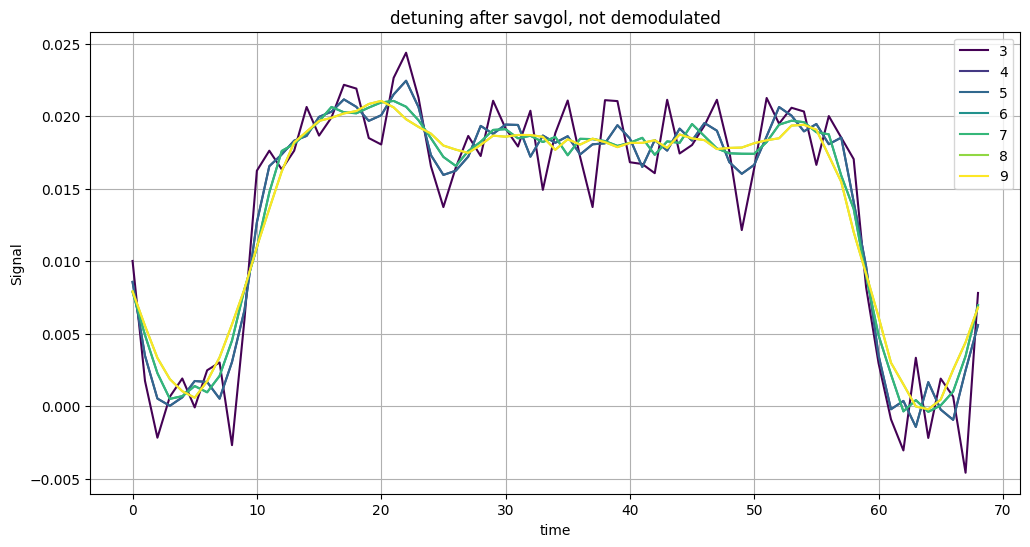

In [35]:
colors = plt.cm.viridis(np.linspace(0, 1, len(result_svg_dem)))

plt.figure(figsize=(12, 6)) 

for i, detuning in enumerate(result_svg_dem):
    plt.plot(detuning.detuning["D1"], color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("detuning after savgol, not demodulated")
plt.legend()
plt.grid()
plt.show()

### Amplitude plots

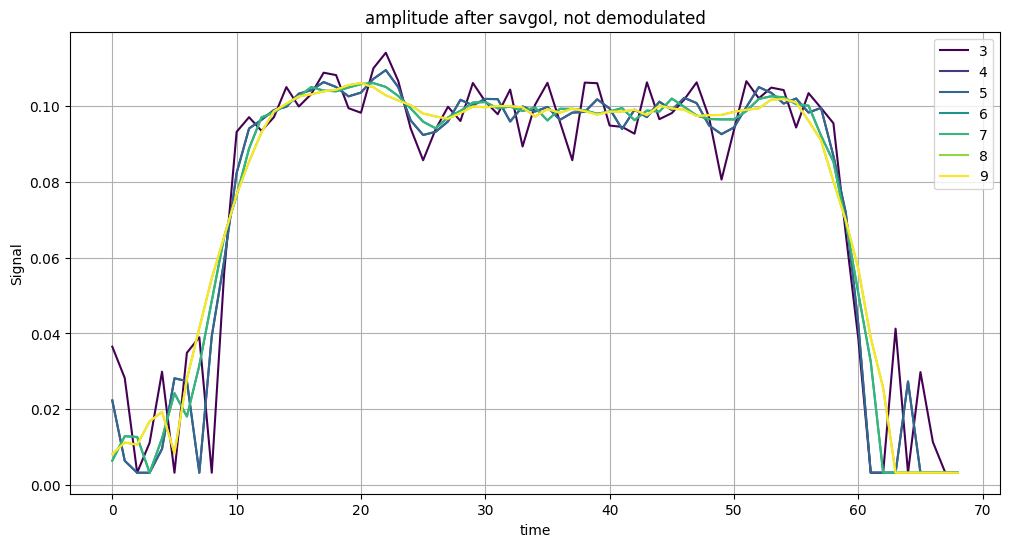

In [40]:
colors = plt.cm.viridis(np.linspace(0, 1, len(result_svg_no_dem)))

plt.figure(figsize=(12, 6)) 

for i, detuning in enumerate(result_svg_no_dem):
    plt.plot(detuning.amplitude["D1"], color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("amplitude after savgol, not demodulated")
plt.legend()
plt.grid()
plt.show()

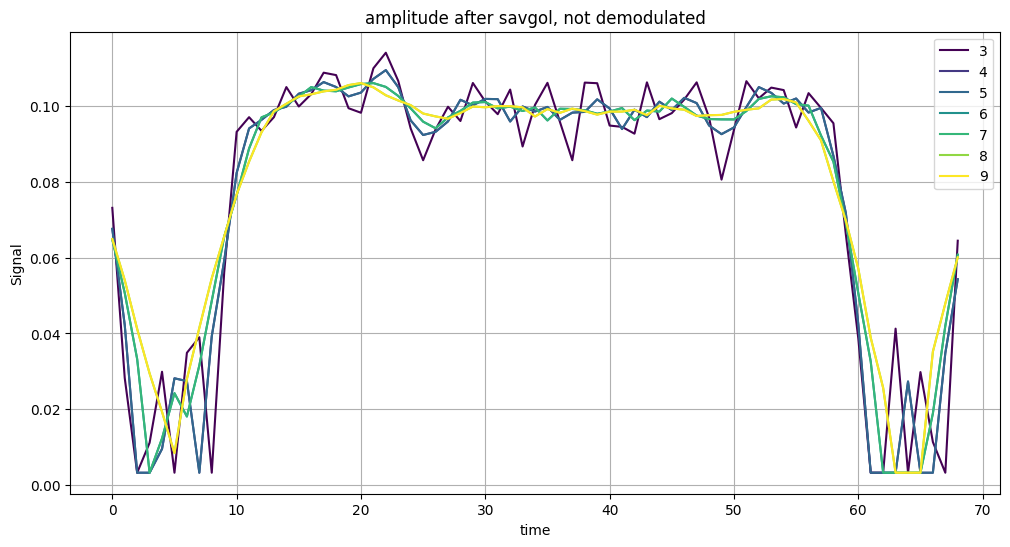

In [39]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6)) 

for i, detuning in enumerate(result_svg_dem):
    plt.plot(detuning.amplitude["D1"], color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("amplitude after savgol, not demodulated")
plt.legend()
plt.grid()
plt.show()

### Considerations on window length

In [15]:
def compute_window_length(data: CryoscopeData, savgol: bool, demod: bool):

    fitted_parameters = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        x = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(x, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (x[1] - x[0])

        # to be used in savgol_filter
        derivative_window_length = 3 / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        derivative_window_size += (derivative_window_size + 1) % 2

    return(derivative_window_size, sampling_rate)

In [16]:
compute_window_length(cryoscope_data, False, False)

(3, 1.0)